In [1]:
import gymnasium as gym
from pogema import GridConfig
from stable_baselines3 import DQN
from stable_baselines3.common.logger import configure
from stable_baselines3.common.evaluation import evaluate_policy

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Load the TensorBoard notebook extension
%load_ext tensorboard

grid_config = GridConfig(
    size=8,                 # size of the grid map 8 = (8x8)
    density=0.3,            # obstacle density
    num_agents=1,           # number of agents
    obs_radius=3,           # defines field of view
    max_episode_steps=30,   # time horizon
    seed=1                  # set to None for random obstacles, agents and targets positions at each reset
)

env = gym.make("Pogema-v0",grid_config=grid_config)

/home/bernard/miniconda3/envs/rlenv/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:29: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: float32. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(
/home/bernard/miniconda3/envs/rlenv/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:34: UserWarning: WARN: It seems a Box observation space is an image but the lower and upper bounds are not [0, 255]. Actual lower bound: -1.0, upper bound: 1.0. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  logger.warn(


### DQN

Sources: 

* https://github.com/Stable-Baselines-Team/rl-colab-notebooks/blob/sb3/dqn_sb3.ipynb
* https://github.com/araffin/rl-tutorial-jnrr19/blob/sb3/1_getting_started.ipynb
* https://stable-baselines3.readthedocs.io/en/master/guide/tensorboard.html
    * https://stable-baselines3.readthedocs.io/en/master/common/logger.html#logger
    * https://www.tensorflow.org/tensorboard/get_started

In [2]:
dqn_model = DQN(
    "MlpPolicy",
    env,
    verbose=1,
    train_freq=16,
    gradient_steps=8,
    gamma=0.99,
    exploration_fraction=0.2,
    exploration_final_eps=0.07,
    target_update_interval=600,
    learning_starts=1000,
    buffer_size=10000,
    batch_size=128,
    learning_rate=4e-3,
    policy_kwargs=dict(net_arch=[256, 256]),
    seed=42,
    tensorboard_log="./tensorboard"
)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [3]:
# Evaluate untrained agent using separate env

val_env = gym.make("Pogema-v0",grid_config=grid_config)

val_dqn_model = DQN(
    "MlpPolicy",
    val_env,
    verbose=1,
    train_freq=16,
    gradient_steps=8,
    gamma=0.99,
    exploration_fraction=0.2,
    exploration_final_eps=0.07,
    target_update_interval=600,
    learning_starts=1000,
    buffer_size=10000,
    batch_size=128,
    learning_rate=4e-3,
    policy_kwargs=dict(net_arch=[256, 256]),
    seed=42,
)

mean_reward, std_reward = evaluate_policy(
    val_dqn_model,
    val_dqn_model.get_env(),
    deterministic=True,
    n_eval_episodes=20,
)

print(f"mean_reward: {mean_reward:.2f} +/- {std_reward:.2f}")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
mean_reward: 0.00 +/- 0.00


In [20]:
# Train agent and save it
dqn_model.learn(total_timesteps=int(3.0e4), tb_log_name="dqn_baseline")
dqn_model.save("saved/dqn_baseline")

Logging to ./tensorboard/dqn_baseline_2
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 26       |
|    ep_rew_mean      | 0.25     |
|    exploration_rate | 0.984    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 7152     |
|    time_elapsed     | 0        |
|    total_timesteps  | 104      |
----------------------------------


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28       |
|    ep_rew_mean      | 0.125    |
|    exploration_rate | 0.965    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 7425     |
|    time_elapsed     | 0        |
|    total_timesteps  | 224      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.7     |
|    ep_rew_mean      | 0.167    |
|    exploration_rate | 0.947    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 8225     |
|    time_elapsed     | 0        |
|    total_timesteps  | 344      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 28.8     |
|    ep_rew_mean      | 0.188    |
|    exploration_rate | 0.929    |
| time/               |          |
|    episodes       

### Load trained agent and evaluate it

In [4]:
dqn_model = DQN.load("saved/dqn_baseline")

env.reset()

mean_reward, std_reward = evaluate_policy(dqn_model, env, deterministic=True, n_eval_episodes=20)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

/home/bernard/miniconda3/envs/rlenv/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward:0.00 +/- 0.00


### Video Recording

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

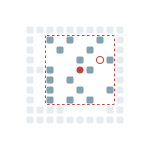

In [13]:
from IPython.display import SVG, display
from pogema.animation import AnimationMonitor, AnimationConfig

env = AnimationMonitor(env)

obs, info = env.reset()

# terminated = truncated = [False, ...]

# while not all(terminated) and not all(truncated):
#     # Use random policy to make actions
#     obs, reward, terminated, truncated, info = env.step([env.action_space.sample() for _ in range(grid_config.num_agents)])

terminated = truncated = False
step = 0


while not terminated or not truncated:
    print(step)
    action, _states = dqn_model.predict(obs)
    # obs, reward, terminated, truncated, info = env.step(env.action_space.sample())
    obs, reward, terminated, truncated, info = env.step(action)
    step += 1

env.save_animation("renders/render.svg", AnimationConfig(egocentric_idx=0))
display(SVG('renders/render.svg'))

### Tensorboard

In [21]:
%tensorboard --logdir tensorboard/dqn_baseline_2

Launching TensorBoard...